# Variational autoencoder

This notebook contains a tutorial on the **variational autoencoder** (VAE). Since its introduction by [[Kingma and Welling, 2014](https://arxiv.org/abs/1312.6114), [Rezende et al., 2014](http://proceedings.mlr.press/v32/rezende14.html)], the framework has received much attention for its generative modeling and representation learning capabilities. Recent reviews are given in [[Doersch, 2016](https://arxiv.org/abs/1606.05908), [Kingma and Welling, 2019](https://doi.org/10.1561/2200000056), [Wei et al., 2020](https://ieeexplore.ieee.org/document/9171997)]. After a brief theoretical discussion, we demonstrate the VAE algorithm on the basis of MNIST data.

## Introduction

Essentially, the VAE is a joint approach to likelihood-based learning of and Bayesian inference in latent variable models with neural networks. It establishes a generative modeling scheme for data with a latent structure. For data generation, the latent variables are randomly drawn from a prior sampling distribution and then transformed. Vice versa, the posterior of the latent variables for a given data point is computed by amortized variational inference. Both the data-generating and the variational distribution are parametrized through neural networks. The VAE admits an interpretation as an unsupervised learning technique and probabilistic extension of the autoencoder, which is used for dimensionality reduction or anomaly detection.

We start by discussing some simple statistical models that can be parametrized by neural networks. This includes simple binary or multiclass classification and distribution fitting. Let us investigate standard (supervised) **classification** first. The goal is the predict the class label $y$ of an input $\boldsymbol{x}$. A neural network $\mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})$ with unknown weights $\boldsymbol{\theta}$ is used the parametrize a conditional probability distribution $\pi_\boldsymbol{\theta}(y | \boldsymbol{x})$. For a multiclass problem the neural network ends with a softmax and models a categorical distribution that can be written using Iverson bracket notation as
$$
\pi_\boldsymbol{\theta}(y | \boldsymbol{x}) =
\mathrm{Categorical}(y | \mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})) =
\prod_{m=1}^M \mathrm{NN}_{\boldsymbol{\theta},m}(\boldsymbol{x})^{[y=c_m]}, \quad
y \in \{c_1, \ldots, c_M\}.
$$
The probability of the $m$-th class is simply represented by the corresponding output component $\pi_\boldsymbol{\theta}(y=c_m | \boldsymbol{x}) = \mathrm{NN}_{\boldsymbol{\theta},m}(\boldsymbol{x})$. Similarly, for a binary classification problem the network would end with a sigmoid function. The probabilities of positive and negative outcomes of a Bernoulli trial are given as $\pi_\boldsymbol{\theta}(y=1 | \boldsymbol{x}) = \mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})$ and $\pi_\boldsymbol{\theta}(y=0 | \boldsymbol{x}) = 1 - \mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})$, respectively. This is summarized as
$$
\pi_\boldsymbol{\theta}(y | \boldsymbol{x}) =
\mathrm{Bernoulli}(y | \mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})) =
\mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x})^y \,
(1 - \mathrm{NN}_\boldsymbol{\theta}(\boldsymbol{x}))^{1-y}, \quad
y \in \{0, 1\}.
$$

Training a classifier, binary or multiclass, requires a set of data that is denoted as $\mathcal{D} = \{(\boldsymbol{x}_i, y_i)\}_{i=1}^N$. A common approach is to maximize the corresponding likelihood function $\pi_\boldsymbol{\theta}(\mathcal{D}) = \prod_{i=1}^N \pi_\boldsymbol{\theta}(y_i | \boldsymbol{x}_i)$.

Another simple statistical model discussed for didactic purposes is (unsupervised) **distribution fitting**. Given a set of data $\mathcal{D} = \{\boldsymbol{x}_i\}_{i=1}^N$ and a model $\boldsymbol{X}_i \sim \pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$, the likelihood function is written as $\pi_\boldsymbol{\theta}(\mathcal{D}) = \prod_{i=1}^N \pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$. The distribution parameters $\boldsymbol{\theta}$ are fitted by maximizing the log-likelihood
$$
\hat{\boldsymbol{\theta}} =
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \,
\log \pi_\boldsymbol{\theta}(\mathcal{D}), \quad
\log \pi_\boldsymbol{\theta}(\mathcal{D}) =
\sum_{i=1}^N \log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i).
$$

Now, consider a **latent variable model** with unobserved variables $\boldsymbol{z}$ that influence the observed ones $\boldsymbol{x}$. The joint probability model is often hierarchically factorized as $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{z}_i) = \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \, \pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)$. A marginalization over the latent variables yields the likelihood for a single data point as
$$
\pi_\boldsymbol{\theta}(\boldsymbol{x}_i) =
\int \pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{z}_i) \, \mathrm{d} \boldsymbol{z}_i =
\int \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \,
\pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i) \, \mathrm{d} \boldsymbol{z}_i.
$$
Based on $\pi_\boldsymbol{\theta}(\mathcal{D}) = \prod_{i=1}^N \pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$ one could learn the distribution parameters $\boldsymbol{\theta} = (\boldsymbol{\theta}_1, \boldsymbol{\theta}_2)$ with all data. Another goal would be to infer the latent variables $\boldsymbol{z}_i$ pertaining to each data point $\boldsymbol{x}_i$ for $i=1,\ldots,N$. This can be accomplished by constructing $i$-specific posterior distributions
$$
\pi_\boldsymbol{\theta}(\boldsymbol{z}_i | \boldsymbol{x}_i) =
\frac{\pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{z}_i)}{\pi_\boldsymbol{\theta}(\boldsymbol{x}_i)} =
\frac{\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \,
\pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)}{\pi_\boldsymbol{\theta}(\boldsymbol{x}_i)}.
$$
Note that the normalizing factor $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$ here is exactly the marginalized likelihood of the latent variable model from above. It is also called the **model evidence** emphasizing its role in model selection.

## Evidence lower bound

In order to represent the posterior, one uses a family of distributions $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ with tunable parameters $\boldsymbol{\phi}$. The latter can be chosen such that it resembles the actual posterior $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \approx \pi_\boldsymbol{\theta}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ in some distributional sense. One now needs a measure the (dis)similarity of two probability densities. To that end, one usually considers the **Kullback-Leibler** (KL) **divergence** from the true posterior to the variational distribution. This so-called relative entropy can be written and decomposed as
$$
D_\mathrm{KL} \left( q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \,
\pi_\boldsymbol{\theta}(\cdot | \boldsymbol{x}_i) \right) =
\int q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \log \left(
\frac{q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i)}{\pi_\boldsymbol{\theta}
(\boldsymbol{z}_i | \boldsymbol{x}_i)} \right) \, \mathrm{d} \boldsymbol{z}_i =
\log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i) -
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i).
$$
The last term $\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$ is called the **free energy** or the **evidence lower bound** (ELBO). It owes its name mentioned second, as a direct consequence of $D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_\boldsymbol{\theta}(\cdot | \boldsymbol{x}_i)) \geq 0$, the fact that $\log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i) \geq \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$. The ELBO is given as
$$
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i) =
\int q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \log \left(
\frac{\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \,
\pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)}{q_\boldsymbol{\phi}
(\boldsymbol{z}_i | \boldsymbol{x}_i)} \right) \, \mathrm{d} \boldsymbol{z}_i.
$$

By definition $D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_\boldsymbol{\theta}(\cdot | \boldsymbol{x}_i))$ establishes a distance between the posterior and its approximation. Equivalently, as it can be seen above, it represents the difference between the logarithm of the marginalized likelihood and its ELBO.

Instead of tackling $N$ $i$-specific problems separately, one can solve them jointly for $i=1,\ldots,N$. One then has $\log \pi_\boldsymbol{\theta}(\mathcal{D}) = \sum_{i=1}^N \log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$ with $\log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i) = D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_\boldsymbol{\theta}(\cdot | \boldsymbol{x}_i)) + \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$. Also, the KL divergence is additive for factorized distributions. Hence, the objective becomes
$$
(\hat{\boldsymbol{\theta}}, \hat{\boldsymbol{\phi}}) =
\underset{\boldsymbol{\theta}, \boldsymbol{\phi}}{\mathrm{argmax}} \,
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\mathcal{D}), \quad
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\mathcal{D}) =
\sum_{i=1}^N \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i).
$$

Note that the parametrized variational distribution is conditioned on an individual data point. This is reminiscent of but also somewhat different from classical **variational inference** [[Blei et al., 2018](https://doi.org/10.1080/01621459.2017.1285773)] where posteriors are approximated by $q_\boldsymbol{\phi}(\boldsymbol{z}_i) \approx \pi_\boldsymbol{\theta}(\boldsymbol{z}_i | \boldsymbol{x}_i)$. Essentially, by estimating $\boldsymbol{\phi}$ it is here learned how to approximately perform Bayesian inference $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ for any $\boldsymbol{x}_i$. This is sometimes called **amortized variational inference**. An interesting discussion of the scheme can be found in [[Zhang et al., 2019](https://doi.org/10.1109/TPAMI.2018.2889774)].

The maximization of the ELBO with respect to the variational parameters $\boldsymbol{\phi}$ improves the **inference model** $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \approx \pi_\boldsymbol{\theta}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ in the sense that it better approximates the posterior distribution. If the ELBO is additionally maximized as function of the generative parameters $\boldsymbol{\theta}$, one might argue that the model evidence $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i)$ is approximately maximized. More precisely, a lower bound of it is maximized. That can be understood as an approximate version of model selection, where the **generative model** $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{z}_i) = \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \, \pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)$ is improved. Both of those objectives become apparent from simply writing the ELBO as $\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i) = \log \pi_\boldsymbol{\theta}(\boldsymbol{x}_i) - D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_\boldsymbol{\theta}(\cdot | \boldsymbol{x}_i))$.

## Encoder and decoder

It is instructive to decompose the ELBO into a term involving the likelihood function and another term involving the prior distribution. This highlights the fact that Bayesian inference finds a compromise between prior and data. The decomposition is
$$
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i) =
\int q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \log \left(
\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \right) \,
\mathrm{d} \boldsymbol{z}_i -
D_\mathrm{KL} \left( q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \,
\pi_{\boldsymbol{\theta}_2}(\cdot) \right).
$$
The first term can be also interpreted as a measure of reconstruction quality, while the second one acts as regularizer. This is reminiscent of a classical **autoencoder** and motivates the following terminology. The variational distribution $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ is called the **probabilistic encoder**, whereas the distribution $\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i)$ is commonly referred to as the **probabilistic decoder**.

The variational distribution can be parametrized in different ways. A common representation is a Gaussian $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) = \mathcal{N}(\boldsymbol{z}_i \, | \, \boldsymbol{\mu}_\boldsymbol{\phi}(\boldsymbol{x}_i), \boldsymbol{\Sigma}_\boldsymbol{\phi}(\boldsymbol{x}_i))$ whose mean vector $\boldsymbol{\mu}_\boldsymbol{\phi}(\boldsymbol{x}_i)$ and covariance matrix $\boldsymbol{\Sigma}_\boldsymbol{\phi}(\boldsymbol{x}_i)$ are predicted by a neural network, for example
$$
q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) =
\mathcal{N} \left( \boldsymbol{z}_i \, | \, \boldsymbol{\mu}_\boldsymbol{\phi}(\boldsymbol{x}_i),
\mathrm{diag} \left( \boldsymbol{\sigma}_\boldsymbol{\phi}^{\odot 2}(\boldsymbol{x}_i) \right) \right) =
\prod_{j=1}^K \mathcal{N} \left( z_{i,j} \, | \, \mu_{\boldsymbol{\phi},j}(\boldsymbol{x}_i),
\sigma_{\boldsymbol{\phi},j}^2(\boldsymbol{x}_i) \right).
$$
Here, the covariance matrix has the diagonal structure $\boldsymbol{\Sigma}_\boldsymbol{\phi}(\boldsymbol{x}_i) = \mathrm{diag}(\sigma_{\boldsymbol{\phi},1}^2(\boldsymbol{x}_i), \ldots, \sigma_{\boldsymbol{\phi},K}^2(\boldsymbol{x}_i))$. Of course, one can construct more complex non-diagonal representations of the covariance.

A deep latent variable model often constitutes the generative part. Take, for instance, a **deep latent Gaussian model** with a Gaussian prior sampling distribution $\pi(\boldsymbol{z}_i) = \mathcal{N}(\boldsymbol{z}_i | \boldsymbol{0}, \boldsymbol{I})$ and another Gaussian $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i | \boldsymbol{z}_i) = \mathcal{N}(\boldsymbol{x}_i \, | \, \boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{z}_i), \boldsymbol{\Sigma}_\boldsymbol{\theta}(\boldsymbol{z}_i))$ as the conditional distribution. An example is
$$
\pi_\boldsymbol{\theta}(\boldsymbol{x}_i | \boldsymbol{z}_i) =
\mathcal{N} \left( \boldsymbol{x}_i \, | \, \boldsymbol{\mu}_\boldsymbol{\theta}(\boldsymbol{z}_i),
\mathrm{diag} \left( \boldsymbol{\sigma}_\boldsymbol{\theta}^{\odot 2}(\boldsymbol{z}_i) \right) \right) =
\prod_{j=1}^L \mathcal{N} \left( x_{i,j} \, | \, \mu_{\boldsymbol{\theta},j}(\boldsymbol{z}_i),
\sigma_{\boldsymbol{\theta},j}^2(\boldsymbol{z}_i) \right).
$$
The vector of means and standard deviations is again computed by a neural network. Instead of the representation of the covariance matrix $\boldsymbol{\Sigma}_\boldsymbol{\theta}(\boldsymbol{z}_i) = \mathrm{diag}(\sigma_{\boldsymbol{\theta},1}^2(\boldsymbol{z}_i), \ldots, \sigma_{\boldsymbol{\theta},L}^2(\boldsymbol{z}_i))$, one can choose a simpler model $\boldsymbol{\Sigma} = \sigma^2 \boldsymbol{I}$ with a constant (fixed or learnable) standard deviation.

Similarly, a **deep latent Bernoulli model** can be used for binary data. Here, a neural network predicts the probability of a positive outcome. The conditional model can then be written as
$$
\pi_\boldsymbol{\theta}(\boldsymbol{x}_i | \boldsymbol{z}_i) =
\prod_{j=1}^L \mathrm{Bernoulli} \left( x_{i,j} \, | \, p_{\boldsymbol{\theta},j}(\boldsymbol{z}_i) \right).
$$
It is remarked that likelihoods based on the Bernoulli distribution should be only used for $\{0,1\}$-valued data [[Loaiza-Ganem and Cunningham, 2019](https://papers.nips.cc/paper/2019/hash/f82798ec8909d23e55679ee26bb26437-Abstract.html), [Yong et al, 2020](http://www.gatsby.ucl.ac.uk/~balaji/udl2020/accepted-papers/UDL2020-paper-063.pdf)]. Despite that, it is sometimes used for nearly binary data sets such as MNIST with continuous pixel intensities in $[0,1]$.

All in all, we have realized that the VAE actually solves several related problems. As for the generative modeling part, the parameters $\boldsymbol{\theta}$ of a generative model $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{z}_i) = \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \, \pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)$ are inferred. At the same time, the parameters $\boldsymbol{\phi}$ of an inference model $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \approx \pi_\boldsymbol{\theta}(\boldsymbol{z}_i | \boldsymbol{x}_i)$ approximating the posterior distribution are estimated. The inference model corresponds to the jointly learned generator. In addition, an autoencoder-like latent representation or code $\boldsymbol{z}_i$ of the original data $\boldsymbol{x}_i$ has emerged.

## Posterior collapse

A number of phenomena where the posterior $q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \approx \pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i)$ merely approximates the prior, at least for some dimensions of $\boldsymbol{z}_i$, are sometimes referred to as **posterior collapse**. Several modes of such a collapse in VAE architectures have been discussed in the literature [[Chen et al., 2017](https://openreview.net/forum?id=BysvGP5ee), [Mattei and Frellsen, 2018](https://papers.nips.cc/paper/2018/hash/0609154fa35b3194026346c9cac2a248-Abstract.html), [Lucas et al., 2019](https://papers.nips.cc/paper/2019/hash/7e3315fe390974fcf25e44a9445bd821-Abstract.html), [Dai et al., 2020](http://proceedings.mlr.press/v119/dai20c.html)]. They can be understood through an investigation of the "balance" between the likelihood and KL terms in $\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i) = \int q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i)) \, \mathrm{d} \boldsymbol{z}_i - D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_{\boldsymbol{\theta}_2}(\cdot))$.

Some forms of posterior collapse are related to the choice of the covariance model of the decoder $\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) = \mathcal{N}(\boldsymbol{x}_i \, | \, \boldsymbol{\mu}_{\boldsymbol{\theta}_1}(\boldsymbol{z}_i), \boldsymbol{\Sigma}_{\boldsymbol{\theta}_1}(\boldsymbol{z}_i))$. A simple representation of the covariance matrix as $\boldsymbol{\Sigma} = \sigma^2 \boldsymbol{I}$ with a constant and too large value of the variance $\sigma^2$ would result in a dominance of the KL term $D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_{\boldsymbol{\theta}_2}(\cdot))$ and eventually encourage the posterior to equal the prior.

For expressive models that represent the covariance as a function $\boldsymbol{\Sigma}_\boldsymbol{\theta}(\boldsymbol{z}_i) = \mathrm{diag}(\sigma_{\boldsymbol{\theta},1}^2(\boldsymbol{z}_i), \ldots, \sigma_{\boldsymbol{\theta},L}^2(\boldsymbol{z}_i))$, if one would have $x_{i,j} \approx \mu_{\boldsymbol{\theta},j}(\boldsymbol{z}_i)$, the likelihood could be arbitrarily maximized by decreasing the variance $\sigma_{\boldsymbol{\theta},j}^2(\boldsymbol{z}_i)$. As a consequence of this collapse of the likelihood around a data point, the model does not necessarily learn anything useful beyond that point.

Another reported form of posterior collapse might happen in case that powerful decoders $\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i)$ are used. They typically do not have the simple Gaussian structure discussed above, but an autoregressive form of dependencies for example. If such a representation is expressive enough to assign a high value to the data point $\boldsymbol{x}_i$ without utilizing the latent variables $\boldsymbol{z}_i$, the posterior collapses to the prior as per Bayes' law.

## Stochastic optimization

For a practical solution of the stochastic optimization problem that arises, the ELBO $\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$ or its gradient $\nabla_{\boldsymbol{\theta}, \boldsymbol{\phi}} \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$ with respect to the parameters of the probabilistic decoder and encoder need to be evaluated. To that end, one may start from one the following two equivalent ways of writing the optimization objective as an expected value
$$
\mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i) =
\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)} \left[ \log \left(
\pi_\boldsymbol{\theta}(\boldsymbol{x}_i, \boldsymbol{Z}_i) \right) -
q_\boldsymbol{\phi} (\boldsymbol{Z}_i | \boldsymbol{x}_i) \right] =
\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)} \left[ \log \left(
\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i) \right) \right] -
D_\mathrm{KL} \left( q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \,
\pi_{\boldsymbol{\theta}_2}(\cdot) \right).
$$

The second way is beneficial if the KL term $D_\mathrm{KL}(q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) \, \| \, \pi_{\boldsymbol{\theta}_2}(\cdot))$ can be evaluated analytically, which happens for instance if both distributions are Gaussian. In the simplest case that $\pi_{\boldsymbol{\theta}_2}(\cdot) = \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ and $q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) = \mathcal{N}((\mu_{\boldsymbol{\phi},1}(\boldsymbol{x}_i),\ldots,\mu_{\boldsymbol{\phi},K}(\boldsymbol{x}_i)), \mathrm{diag}(\sigma_{\boldsymbol{\phi},1}^2(\boldsymbol{x}_i),\ldots,\sigma_{\boldsymbol{\phi},K}^2(\boldsymbol{x}_i)))$, one has
$$
D_\mathrm{KL} \left( \mathcal{N}((\mu_1, \ldots, \mu_K),
\mathrm{diag}(\sigma_1^2, \ldots, \sigma_K^2)) \, \| \,
\mathcal{N}(\boldsymbol{0}, \boldsymbol{I}) \right) =
\frac{1}{2} \sum_{j=1}^K \left( \mu_j^2 + \sigma_j^2 -
\log \sigma_j^2 - 1 \right).
$$

The likelihood term $\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)}[\log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i))]$ turns out to be more involved. It has to be simulated via Monte Carlo sampling in most practical situations. Given samples $\boldsymbol{z}_i^{(t)} \sim q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)$ for $t=1,\ldots,T$ from the variational distribution, the likelihood term can be estimated as
$$
\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)} \left[ \log \left(
\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i) \right) \right]
\approx \frac{1}{T} \sum_{t=1}^T \log \left(
\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i^{(t)}) \right).
$$
Due to their wide applicability, such sampling-based approaches are also called **black box variational inference** [[Ranganath et al., 2014](http://proceedings.mlr.press/v33/ranganath14.html)]. A special case of such a scheme uses only a single sample $T=1$ in order to estimate the likelihood term as $\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)}[\log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i))] \approx \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i^{(1)}))$.

At this point, the sampling efficiency of the Monte Carlo approach needs to be discussed briefly. Since the variational distribution $q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)$ for estimating the term $\int q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i)) \, \mathrm{d} \boldsymbol{z}_i$ is expected to better and better approximate the posterior during training, sampling from it produces high-likelihood samples. Such latent values have likely generated the data point under the generative model. This is significantly more efficient than sampling from the prior distribution $\pi_{\boldsymbol{\theta}_2}(\cdot)$, typically yielding low-likelihood samples, in order to estimate the marginal likelihood $\pi_\boldsymbol{\theta}(\boldsymbol{x}_i) = \int \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i) \, \pi_{\boldsymbol{\theta}_2}(\boldsymbol{z}_i) \, \mathrm{d} \boldsymbol{z}_i$.

While the gradient $\nabla_\boldsymbol{\theta} \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$ can be estimated by using a sampling strategy, it does not work so easily for $\nabla_\boldsymbol{\phi} \mathcal{F}_{\boldsymbol{\theta}, \boldsymbol{\phi}}(\boldsymbol{x}_i)$. The reason is that one can readily use $\nabla_{\boldsymbol{\theta}_1} \mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)}[\log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i))] = \mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)}[\nabla_{\boldsymbol{\theta}_1} \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i))] \approx T^{-1} \sum_t \nabla_{\boldsymbol{\theta}_1} \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i^{(t)}))$, whereas it is not immediately clear how one should proceed with $\nabla_\boldsymbol{\phi} \mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)}[\log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i))] = \int \log(\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{z}_i)) \, \nabla_\boldsymbol{\phi} q_\boldsymbol{\phi}(\boldsymbol{z}_i | \boldsymbol{x}_i) \, \mathrm{d} \boldsymbol{z}_i$. Here, the gradient occurs with respect to a distributional parameter of the expectation. The latter integral does not have the mathematical form of an expectation.

A review of noisy gradient estimation for stochastic optimization is provided in [[Mohamed et al., 2020](https://jmlr.org/papers/v21/19-346.html)]. The so-called **score function estimator** is unbiased but typically has a high variance. A better alternative is often the **reparametrization trick**. Here, one introduces an auxiliary random variable $\boldsymbol{\mathcal{E}}_i \sim p$ following a simple distribution and a random variable transformation with $\boldsymbol{Z}_i = g_\boldsymbol{\phi}(\boldsymbol{\mathcal{E}}_i, \boldsymbol{x}_i) \sim q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)$. One can then write
$$
\mathbb{E}_{q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i)} \left[ \log \left(
\pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i | \boldsymbol{Z}_i) \right) \right] =
\mathbb{E}_p \left[ \log \left( \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i |
g_\boldsymbol{\phi}(\boldsymbol{\mathcal{E}}_i, \boldsymbol{x}_i)) \right) \right].
$$

This follows from the law of the unconscious statistician. Now the expectation is taken with respect to a fixed base distribution. It therefore commutes with the gradient operator such that one can approximate the required gradient through Monte Carlo sampling
$$
\nabla_{\boldsymbol{\theta}_1, \boldsymbol{\phi}}
\mathbb{E}_p \left[ \log \left( \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i |
g_\boldsymbol{\phi}(\boldsymbol{\mathcal{E}}_i, \boldsymbol{x}_i)) \right) \right] =
\mathbb{E}_p \left[ \nabla_{\boldsymbol{\theta}_1, \boldsymbol{\phi}}
\log \left( \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i |
g_\boldsymbol{\phi}(\boldsymbol{\mathcal{E}}_i, \boldsymbol{x}_i)) \right) \right] \approx
\frac{1}{T} \sum_{t=1}^T \nabla_{\boldsymbol{\theta}_1, \boldsymbol{\phi}}
\log \left( \pi_{\boldsymbol{\theta}_1}(\boldsymbol{x}_i |
g_\boldsymbol{\phi}(\boldsymbol{\epsilon}_i^{(t)}, \boldsymbol{x}_i)) \right).
$$
The samples $\boldsymbol{\epsilon}_i^{(t)} \sim p$ are drawn from the base distribution for $t=1,\ldots,T$. In case that the base is $p = \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ and the variational distribution is $q_\boldsymbol{\phi}(\cdot | \boldsymbol{x}_i) = \mathcal{N}(\boldsymbol{\mu}_\boldsymbol{\phi}(\boldsymbol{x}_i), \mathrm{diag}(\boldsymbol{\sigma}_\boldsymbol{\phi}^{\odot 2}(\boldsymbol{x}_i)))$, the reparametrization is appealingly simple. It is just given as
$$
\boldsymbol{z}_i^{(t)} = g_\boldsymbol{\phi}(\boldsymbol{\epsilon}_i^{(t)}, \boldsymbol{x}_i) =
\boldsymbol{\mu}_\boldsymbol{\phi}(\boldsymbol{x}_i) +
\boldsymbol{\sigma}_\boldsymbol{\phi}(\boldsymbol{x}_i) \odot \boldsymbol{\epsilon}_i^{(t)}.
$$

Eventually, one has an estimator of the ELBO gradient based on Monte Carlo simulation at hand. This noisy gradient can be used in conjunction with all available backpropagation-based optimization schemes to maximize the ELBO.

## Demonstration

After this abstract introduction, it is time for a real demonstration. We therefore apply a Bernoulli VAE to binarized MNIST images. PyTorch is used as a deep learning library. The quality of the VAE to encode/decode for data compression and generation purposes is investigated. Two different neural network architectures, namely with fully connected and convolutional layers, are experimented with.

In [1]:
%matplotlib inline

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### MNIST data

It is started by importing the MNIST data set. Since, as we have previously discussed, the Bernoulli likelihood strictly speaking requires binary-valued data, the images are binarized as part of the preprocessing. Standard PyTorch `Dataset`s and `DataLoader`s generate mini-batches of data during training and inference. Of course, it would be possible to use random digit-preserving image transformations for data augmentation.

In [3]:
preprocessor = transforms.Compose([
    transforms.ToTensor(),
    lambda x: torch.where(x > 0.5, 1, 0).float()
])

In [4]:
data_path = pathlib.Path.home() / 'Data'
train_set = datasets.MNIST(data_path,
                           train=True,
                           transform=preprocessor,
                           download=True)
test_set = datasets.MNIST(data_path,
                          train=False,
                          transform=preprocessor,
                          download=True)
print('No. train images:', len(train_set))
print('No. test images:', len(test_set))

No. train images: 60000
No. test images: 10000


In [5]:
train_batch_size = 64
test_batch_size = 128
train_loader = DataLoader(train_set,
                          batch_size=train_batch_size,
                          shuffle=True)
test_loader = DataLoader(test_set,
                         batch_size=test_batch_size,
                         shuffle=True)
print('No. train batches:', len(train_loader))
print('No. test batches:', len(test_loader))

No. train batches: 938
No. test batches: 79


In [6]:
images, labels = next(iter(train_loader))
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


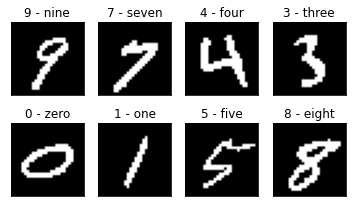

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(5,3))
for idx, ax in enumerate(axes.ravel()):
    image = images[idx,0].numpy()
    ax.imshow(image.clip(0,1), cmap='gray')
    ax.set_title(train_set.classes[labels[idx]])
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()
fig.show()

### Bernoulli VAE

A VAE scheme for Bernoulli likelihoods is implemented in the class `BernoulliVAE`. It is essentially a wrapper for suitable encoder and decoder models and provides methods for training and inference. The construction as a wrapper class allows for flexibly experimenting with different architectures. This includes the fully connected and convolutional neural network encoders/decoders that are defined shortly afterwards.

In [8]:
class BernoulliVAE():
    '''
    Variational autoencoder with Bernoulli likelihoods.

    Summary
    -------
    This class establishes a Bernoulli VAE scheme.
    It is initialized with an encoder and decoder model.
    The encoder represents the variational distribution
    of the latent variables as a diagonal Gaussian.
    It predicts means and logarithms of standard deviations.
    The decoder realizes a multivariate Bernoulli distribution
    over the data space, which also defines the likelihood.
    It predicts the corresponding logits to that end.

    Parameters
    ----------
    encoder : PyTorch module
        Encoder model predicting means and
        logarithms of standard deviations.
    decoder : PyTorch module
        Decoder model predicting Bernoulli logits.
    device : PyTorch device
        Device the computations are performed on.

    '''

    def __init__(self, encoder, decoder, device=None):
        self.encoder = encoder
        self.decoder = decoder
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        self.sampling = True
        self.epoch = 0

    def sample(self, sample_mode=True):
        '''Set sampling mode.'''
        self.sampling = sample_mode

    def train(self, train_mode=True):
        '''Set training mode.'''
        self.encoder.train(train_mode)
        self.decoder.train(train_mode)
        if train_mode:
            self.sample(True)

    def encode(self, X):
        '''Encode the input variables.'''
        mu, logsigma = self.encoder(X)
        return mu, logsigma

    def reparametrize(self, mu, logsigma):
        '''Sample the latent variables.'''
        if self.sampling:
            sigma = torch.exp(logsigma)
            eps = torch.randn_like(sigma)
            z = mu + sigma * eps
        else:
            z = mu
        return z

    def decode(self, z):
        '''Decode the latent variables.'''
        logits = self.decoder(z)
        return logits

    def __call__(self, X):
        '''Encode, sample, decode.'''
        mu, logsigma = self.encode(X)
        z = self.reparametrize(mu, logsigma)
        logits = self.decode(z)
        probs = torch.sigmoid(logits)
        return probs

    def kl(self, mu, logsigma):
        '''Compute the KL divergence.'''
        kl = 0.5 * torch.sum(mu**2 + torch.exp(logsigma)**2 - 2*logsigma - 1,
                             dim=[i for i in range(1, mu.ndim)]) # sum over data dimensions (all but batch)
        return kl

    def ll(self, X_logits, X):
        '''Compute the log-likelihood.'''
        # ll = torch.sum(-nn.functional.binary_cross_entropy_with_logits(X_logits, X, reduction='none'),
        #                dim=[_ for _ in range(1, X.ndim)])
        ll = torch.sum(dist.Bernoulli(logits=X_logits).log_prob(X.float()),
                       dim=[_ for _ in range(1, X.ndim)]) # sum over data dimensions (all but batch)
        return ll

    def elbo(self, X, no_samples=1):
        '''Estimate the ELBO objective.'''
        mu, logsigma = self.encode(X)
        kl = self.kl(mu, logsigma)
        ll = torch.zeros_like(kl)
        for _ in range(no_samples):
            z_sample = self.reparametrize(mu, logsigma)
            X_logits = self.decode(z_sample)
            ll += self.ll(X_logits, X)
        ll /= no_samples
        elbo = torch.mean(ll - kl) # mean over data points (only batch dimension)
        return elbo

    def loss(self, X, no_samples=1):
        '''Estimate the negative-ELBO loss.'''
        loss = -self.elbo(X, no_samples)
        return loss

    def compile_for_training(self, optimizer, train_loader, test_loader=None):
        '''Compile for training.'''
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader

    def training(self, no_epochs, no_samples=1, log_interval=None, initial_test=True):
        '''Perform a number of training epochs.'''
        train_losses = []
        test_losses = []
        if initial_test:
            train_loss = self.test_loss(self.train_loader, no_samples, all_batches=False)
            test_loss = self.test_loss(self.test_loader, no_samples, all_batches=False)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            print('Started training: {}, test loss: {:.4e}' \
                  .format(self.epoch, test_loss))
        for epoch_idx in range(no_epochs):
            train_loss = self.train_epoch(no_samples, log_interval)
            train_losses.append(train_loss)
            self.epoch += 1
            if self.test_loader is not None:
                test_loss = self.test_loss(no_samples=no_samples, all_batches=False)
                test_losses.append(test_loss)
                print('Finished epoch: {}, test loss: {:.4e}' \
                      .format(self.epoch, test_loss))
        history = {'no_epochs': no_epochs,
                   'train_loss': train_losses,
                   'test_loss': test_losses}
        return history

    def train_epoch(self, no_samples=1, log_interval=None):
        '''Perform a single training epoch.'''
        self.sample(True)
        self.train(True)
        batch_losses = []
        for batch_idx, (X_batch, _) in enumerate(self.train_loader):
            X_batch = X_batch.to(self.device)
            self.optimizer.zero_grad()
            loss = self.loss(X_batch, no_samples=no_samples)
            loss.backward()
            self.optimizer.step()
            batch_loss = loss.data.item()
            batch_losses.append(batch_loss)
            if len(batch_losses) < 3:
                running_loss = batch_loss
            else:
                running_loss = sum(batch_losses[-3:]) / 3
            if log_interval is not None:
                if (batch_idx+1) % log_interval == 0 or (batch_idx+1) == len(self.train_loader):
                    print('Epoch: {} ({}/{}), batch loss: {:.4e}, running loss: {:.4e}' \
                          .format(self.epoch+1, batch_idx+1, len(self.train_loader), batch_loss, running_loss))
        return running_loss

    def test_loss(self, test_loader=None, no_samples=1, all_batches=False):
        '''Compute loss over a test set.'''
        if test_loader is None:
            test_loader = self.test_loader
        self.sample(True)
        self.train(False)
        with torch.no_grad():
            if all_batches: # all batches
                test_loss = 0.0
                for X_batch, _ in test_loader:
                    X_batch = X_batch.to(self.device)
                    loss = self.loss(X_batch, no_samples=no_samples)
                    test_loss += loss.data.item()
            else: # only one batch
                X_batch, _ = next(iter(test_loader))
                X_batch = X_batch.to(self.device)
                loss = self.loss(X_batch, no_samples=no_samples)
                test_loss = loss.data.item()
        return test_loss

### Fully connected encoder/decoder

Exemplary encoder/decoder architectures for MNIST are constructed below. The two simple neural networks `DenseEncoder` and `DenseDecoder` have four fully connected layers each. The number of neurons in each layer can be freely chosen. Nonlinear ReLU activation functions are used where appropriate. The images are flattened when being passed to the encoder and reshaped to the original resolution by the decoder.

In [9]:
class DenseEncoder(nn.Module):
    '''Fully connected encoder.'''

    def __init__(self,
                 no_hidden1,
                 no_hidden2,
                 no_hidden3,
                 no_latent):
        super().__init__()
        self.fc1 = nn.Linear(784, no_hidden1)
        self.fc2 = nn.Linear(no_hidden1, no_hidden2)
        self.fc3 = nn.Linear(no_hidden2, no_hidden3)
        self.fc41 = nn.Linear(no_hidden3, no_latent)
        self.fc42 = nn.Linear(no_hidden3, no_latent)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = nn.functional.leaky_relu(self.fc3(x))
        mu = self.fc41(x)
        logsigma = self.fc42(x)
        return mu, logsigma

class DenseDecoder(nn.Module):
    '''Fully connected decoder.'''

    def __init__(self,
                 no_latent,
                 no_hidden1,
                 no_hidden2,
                 no_hidden3):
        super().__init__()
        self.fc1 = nn.Linear(no_latent, no_hidden1)
        self.fc2 = nn.Linear(no_hidden1, no_hidden2)
        self.fc3 = nn.Linear(no_hidden2, no_hidden3)
        self.fc4 = nn.Linear(no_hidden3, 784)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = nn.functional.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, 1, 28, 28)
        return x

### Convolutional encoder/decoder

As an alternative, `ConvEncoder` and `ConvDecoder` feature convolutional layers in addition to fully connected ones. The number of feature maps can be arbitrarily set. While the encoder contains standard convolutions and downscaling operations, the decoder utilizes interpolation-based upscalings and convolutions. The employment of transposed convolutions is another possibility, despite occasionally suffering from checkerboard artifacts.

In [10]:
class ConvEncoder(nn.Module):
    '''Convolutional encoder.'''

    def __init__(self,
                 no_channels1,
                 no_channels2,
                 no_hidden,
                 no_latent):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_channels1, (3,3), padding=1)
        self.conv2 = nn.Conv2d(no_channels1, no_channels1, (3,3), padding=1)
        self.conv3 = nn.Conv2d(no_channels1, no_channels2, (3,3), padding=1)
        self.conv4 = nn.Conv2d(no_channels2, no_channels2, (3,3), padding=1)
        self.fc1 = nn.Linear(no_channels2*7*7, no_hidden)
        self.fc21 = nn.Linear(no_hidden, no_latent)
        self.fc22 = nn.Linear(no_hidden, no_latent)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x))
        x = nn.functional.leaky_relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = nn.functional.leaky_relu(self.conv3(x))
        x = nn.functional.leaky_relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.leaky_relu(self.fc1(x))
        mu = self.fc21(x)
        logsigma = self.fc22(x)
        return mu, logsigma

class ConvDecoder(nn.Module):
    '''Convolutional decoder.'''

    def __init__(self,
                 no_latent,
                 no_hidden,
                 no_channels1,
                 no_channels2,
                 conv_transpose=False):
        super().__init__()
        self.fc1 = nn.Linear(no_latent, no_hidden)
        self.fc2 = nn.Linear(no_hidden, no_channels1*7*7)
        if conv_transpose:
            ConvLayer = nn.ConvTranspose2d
        else:
            ConvLayer = nn.Conv2d
        self.conv1 = ConvLayer(no_channels1, no_channels1, (3,3), padding=1)
        self.conv2 = ConvLayer(no_channels1, no_channels2, (3,3), padding=1)
        self.conv3 = ConvLayer(no_channels2, no_channels2, (3,3), padding=1)
        self.conv4 = ConvLayer(no_channels2, 1, (3,3), padding=1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = x.view(-1, self.conv1.in_channels, 7, 7)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = nn.functional.leaky_relu(self.conv1(x))
        x = nn.functional.leaky_relu(self.conv2(x))
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = nn.functional.leaky_relu(self.conv3(x))
        x = self.conv4(x)
        return x

### Fully connected VAE with two-dimensional latent space

In a first experiment, we visualize the latent space of a Bernoulli VAE on binarized MNIST. Encoder and decoder are instances of the four-layer fully connected neural nets defined above. The dimensionality of the latent space it set to only two. This is an arbitrary choice that facilitates the visual investigation of the encoding. Further architectural details and the training setup are specified in the cells below.

In [11]:
no_hidden1 = 512
no_hidden2 = 128
no_hidden3 = 24
no_latent = 2
dense_encoder = DenseEncoder(no_hidden1, no_hidden2, no_hidden3, no_latent)
dense_decoder = DenseDecoder(no_latent, no_hidden3, no_hidden2, no_hidden1)
dense_vae = BernoulliVAE(dense_encoder, dense_decoder)
print(dense_encoder)
print(dense_decoder)

DenseEncoder(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (fc41): Linear(in_features=24, out_features=2, bias=True)
  (fc42): Linear(in_features=24, out_features=2, bias=True)
)
DenseDecoder(
  (fc1): Linear(in_features=2, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)


In [12]:
optimizer = torch.optim.Adam([{'params': dense_encoder.parameters()},
                              {'params': dense_decoder.parameters()}], lr=0.001)
dense_vae.compile_for_training(optimizer, train_loader, test_loader)

The VAE is quickly trained for 20 epochs. We monitor and plot the ELBO-based loss on both the train and test set. A single Monte Carlo sample is used in order to estimate the objective for each data point in a batch. The loss estimate is noisy due to this and, as usual, the randomized mini-batching.

In [13]:
dense_history = dense_vae.training(no_epochs=20, no_samples=1, log_interval=None)

Started training: 0, test loss: 5.4438e+02
Finished epoch: 1, test loss: 1.6283e+02
Finished epoch: 2, test loss: 1.5034e+02
Finished epoch: 3, test loss: 1.3321e+02
Finished epoch: 4, test loss: 1.4277e+02
Finished epoch: 5, test loss: 1.4127e+02
Finished epoch: 6, test loss: 1.3361e+02
Finished epoch: 7, test loss: 1.4430e+02
Finished epoch: 8, test loss: 1.3830e+02
Finished epoch: 9, test loss: 1.3153e+02
Finished epoch: 10, test loss: 1.3780e+02
Finished epoch: 11, test loss: 1.2848e+02
Finished epoch: 12, test loss: 1.3531e+02
Finished epoch: 13, test loss: 1.4035e+02
Finished epoch: 14, test loss: 1.3888e+02
Finished epoch: 15, test loss: 1.3244e+02
Finished epoch: 16, test loss: 1.3728e+02
Finished epoch: 17, test loss: 1.3994e+02
Finished epoch: 18, test loss: 1.2673e+02
Finished epoch: 19, test loss: 1.3176e+02
Finished epoch: 20, test loss: 1.3472e+02


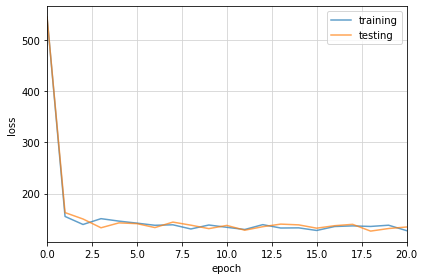

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.array(dense_history['train_loss']), label='training', alpha=0.7)
ax.plot(np.array(dense_history['test_loss']), label='testing', alpha=0.7)
ax.set(xlabel='epoch', ylabel='loss')
ax.set_xlim([0, dense_history['no_epochs']])
ax.legend()
ax.grid(b=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()

The trained encoder is in the following applied to the whole test set. Since this actually yields diagonal Gaussian distributions, only the mean vectors are used as the encodings. The alternative would be to take the full distributions or to simply generate random samples from them.

In [15]:
def encode_loader(vae, data_loader):
    '''Encode all items in a data loader.'''
    vae.sample(False)
    vae.train(False)
    z_mu = []
    z_sigma = []
    y = []
    for X_batch, y_batch in data_loader:
        with torch.no_grad():
            X_batch = X_batch.to(vae.device)
            y_batch = y_batch.to(vae.device)
            z_batch_mu, z_batch_logsigma = vae.encode(X_batch)
            z_batch_mu = z_batch_mu
            z_batch_sigma = torch.exp(z_batch_logsigma)
        z_mu.append(z_batch_mu)
        z_sigma.append(z_batch_sigma)
        y.append(y_batch)
    z_mu = torch.cat(z_mu, dim=0)
    z_sigma = torch.cat(z_sigma, dim=0)
    y = torch.cat(y, dim=0)
    return z_mu, z_sigma, y

In [16]:
z_mu, z_sigma, y = encode_loader(dense_vae, test_loader)
z_mu = z_mu.cpu()
z_sigma = z_sigma.cpu()
y = y.cpu()

We can now plot the computed points in the two-dimensional latent space. Points belonging to different digits have different colors. While the VAE has not used any class label information during training, it is interesting to observe how the classes are organized in the latent space.

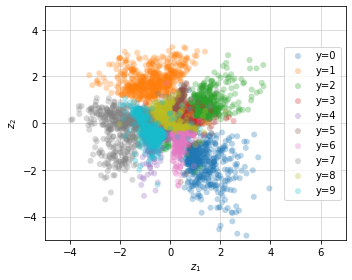

In [17]:
fig, ax = plt.subplots(figsize=(5,4))
for idx in range(10):
    ax.scatter(z_mu[y==idx,0][::2], z_mu[y==idx,1][::2], color=plt.cm.tab10(idx),
               alpha=0.3, edgecolors='none', label='y={}'.format(idx))
ax.set(xlabel='$z_1$', ylabel='$z_2$', xlim=(-5,7), ylim=(-5,5))
ax.legend(loc='center right')
ax.grid(b=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()

### Convolutional VAE with 32-dimensional latent space

Of course, instead of using fully connected encoder and decoder networks, one can use convolutional ones. They embody prior expectations regarding vision applications, for example hierarchical representations and a certain translation invariance. Based on those principles, experiments regarding data encoding, reconstruction and generation are performed. We start with the initialization of a convolutional VAE with 32 latent variables.

In [18]:
no_channels1 = 16
no_channels2 = 24
no_hidden = 256
no_latent = 32
conv_encoder = ConvEncoder(
    no_channels1,
    no_channels2,
    no_hidden,
    no_latent
)
conv_decoder = ConvDecoder(
    no_latent,
    no_hidden,
    no_channels2,
    no_channels1,
    conv_transpose=False
)
conv_vae = BernoulliVAE(conv_encoder, conv_decoder)
print(conv_encoder)
print(conv_decoder)

ConvEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1176, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=32, bias=True)
  (fc22): Linear(in_features=256, out_features=32, bias=True)
)
ConvDecoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1176, bias=True)
  (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [19]:
optimizer = torch.optim.Adam([{'params': conv_encoder.parameters()},
                              {'params': conv_decoder.parameters()}], lr=0.001)
conv_vae.compile_for_training(optimizer, train_loader, test_loader)

The convolutional VAE is trained for 100 epochs. This takes significantly longer than the 20 epochs for the fully connected architecture. Again, a single-sample estimator of the loss and its gradient is employed. It was observed here that higher sample numbers have not improved convergence.

In [20]:
conv_history = conv_vae.training(no_epochs=100, no_samples=1, log_interval=None)

Started training: 0, test loss: 5.3414e+02
Finished epoch: 1, test loss: 1.0285e+02
Finished epoch: 2, test loss: 8.9405e+01
Finished epoch: 3, test loss: 8.6495e+01
Finished epoch: 4, test loss: 8.5749e+01
Finished epoch: 5, test loss: 7.9204e+01
Finished epoch: 6, test loss: 7.7991e+01
Finished epoch: 7, test loss: 7.9453e+01
Finished epoch: 8, test loss: 7.8771e+01
Finished epoch: 9, test loss: 7.7789e+01
Finished epoch: 10, test loss: 7.9219e+01
Finished epoch: 11, test loss: 7.8511e+01
Finished epoch: 12, test loss: 7.7390e+01
Finished epoch: 13, test loss: 7.5390e+01
Finished epoch: 14, test loss: 7.5367e+01
Finished epoch: 15, test loss: 7.4255e+01
Finished epoch: 16, test loss: 7.8435e+01
Finished epoch: 17, test loss: 7.4631e+01
Finished epoch: 18, test loss: 7.2305e+01
Finished epoch: 19, test loss: 7.4859e+01
Finished epoch: 20, test loss: 7.3565e+01
Finished epoch: 21, test loss: 7.3228e+01
Finished epoch: 22, test loss: 7.5069e+01
Finished epoch: 23, test loss: 7.3529e+01


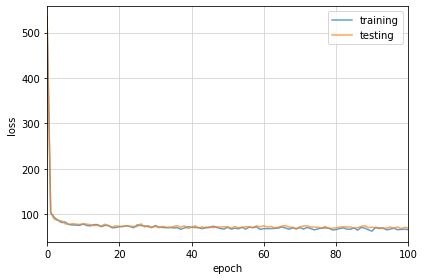

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.array(conv_history['train_loss']), label='training', alpha=0.7)
ax.plot(np.array(conv_history['test_loss']), label='testing', alpha=0.7)
ax.set(xlabel='epoch', ylabel='loss')
ax.set_xlim([0, conv_history['no_epochs']])
ax.legend()
ax.grid(b=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()

Images can now be compressed into their latent representation and subsequently be reconstructed. The following procedure is applied to each binary image in a generated batch. First, the encoding is computed while sampling is turned off. The mean values of the diagonal Gaussian form the encoding. Second, the decoder is used on this latent code also without sampling. Finally, the predicted Bernoulli probabilities constitute the image reconstruction.

In [22]:
X_batch, _ = next(iter(test_loader))
conv_vae.sample(False)
conv_vae.train(False)
with torch.no_grad():
    X_batch = X_batch.to(conv_vae.device)
    X_reconstructed = conv_vae(X_batch)

A random sample of the binarized test images is shown in the first row of the following figure. The second row contains the corresponding image reconstructions. While the reconstruction quality seems to be generally satisfactory, one can observe a certain "blurriness". This is not only a consequence of comparing continuous reconstructions with binary originals, but also a general weakness of VAE models.

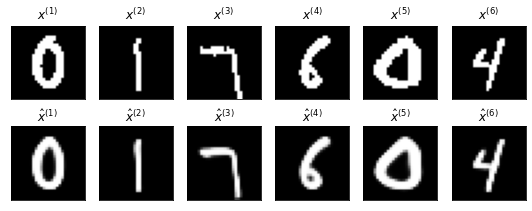

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(7.5,3))
for idx, ax in enumerate(axes[0]):
    image = X_batch[idx,0].cpu().numpy()
    ax.imshow(image.clip(0,1), cmap='gray')
    ax.set_title('$x^{{({})}}$'.format(idx+1))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
for idx, ax in enumerate(axes[1]):
    image = X_reconstructed[idx,0].cpu().numpy()
    ax.imshow(image.clip(0,1), cmap='gray')
    ax.set_title('$\\hat{{x}}^{{({})}}$'.format(idx+1))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()
fig.show()

Another demonstration of how one can use the VAE for generative modeling is now provided. One hundred samples are drawn from the prior sampling distribution of the latent variables. Since this is just a diagonal Gaussian, only standard normal variates have to be generated. Those latent values are subsequently passed to the decoder. The corresponding outputs are collected in a tensor.

In [24]:
no_samples = 100
z_samples = torch.randn(no_samples, no_latent)
conv_vae.sample(True)
conv_vae.train(False)
with torch.no_grad():
    z_samples = z_samples.to(conv_vae.device)
    X_generated = conv_vae.decode(z_samples)

Even though the training data was binarized, the images that are generated this way have continuous pixel values. While the results are certainly not perfect yet, the generated images look already quite realistic. Architectural improvements would likely enhance the generative modeling quality.

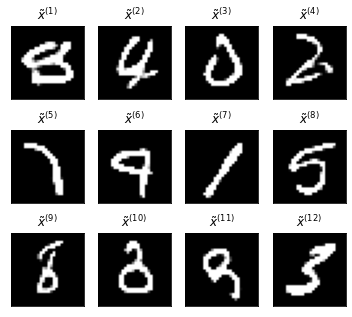

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5,4.5))
for idx, ax in enumerate(axes.ravel()):
    image = X_generated[idx,0].cpu().numpy()
    ax.imshow(image.clip(0,1), cmap='gray')
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
    ax.set_title('$\\tilde{{x}}^{{({})}}$'.format(idx+1))
fig.tight_layout()
fig.show()